In [1]:
# Step 1: Basic setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, average_precision_score
)

# For clean plots
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['axes.grid'] = True


In [2]:
from google.colab import files
uploaded = files.upload()

Saving logistic_regression.csv to logistic_regression.csv


In [3]:
df = pd.read_csv('logistic_regression.csv')
df.head()


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [4]:
df.info()
df.describe(include='all').T
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

,0
loan_amnt,0
term,0
int_rate,0
installment,0
grade,0
sub_grade,0
emp_title,22927
emp_length,18301
home_ownership,0
annual_inc,0


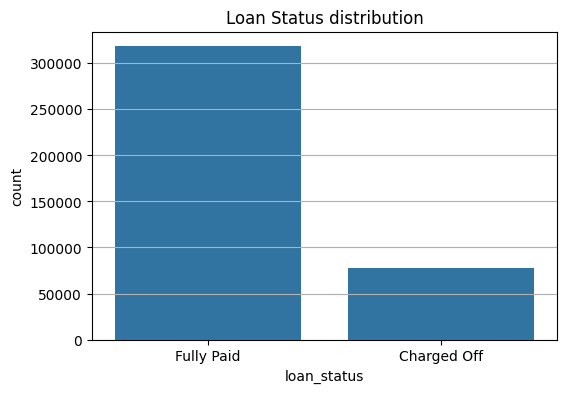

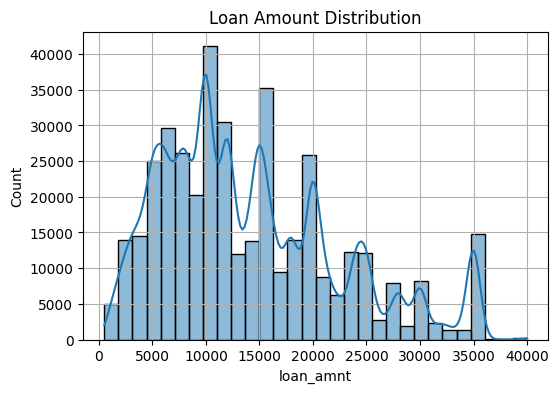

In [5]:
sns.countplot(x='loan_status', data=df)
plt.title("Loan Status distribution")
plt.show()

sns.histplot(df['loan_amnt'], bins=30, kde=True)
plt.title("Loan Amount Distribution")
plt.show()


Text(0.5, 1.0, 'Loan Amount vs Loan Status')

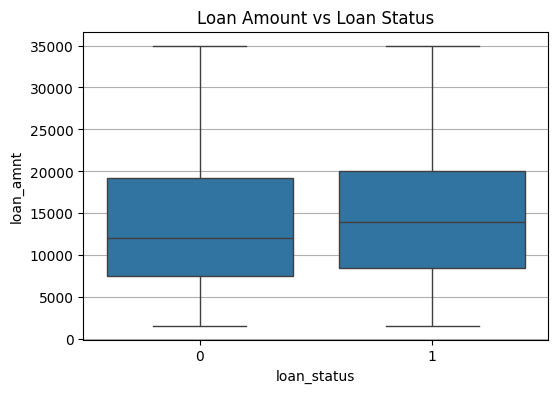

In [16]:
sns.boxplot(x='loan_status', y='loan_amnt', data=df)
plt.title('Loan Amount vs Loan Status')


In [6]:
# Target encoding
df['loan_status'] = df['loan_status'].str.lower()
df['loan_status'] = df['loan_status'].replace({
    'fully paid': 0,
    'current': 0,
    'issued': 0,
    'paid': 0,
    'charged off': 1,
    'default': 1,
    'late (31-120 days)': 1,
    'late (16-30 days)': 1
})

# Binary flags
for c in ['pub_rec','mort_acc','pub_rec_bankruptcies']:
    if c in df.columns:
        df[f'is_{c}_gt1'] = (df[c].fillna(0) > 1).astype(int)

# Drop heavy free-text columns
df = df.drop(columns=['address','emp_title','title'], errors='ignore')

# Handle dates
for d in ['issue_d','earliest_cr_line']:
    if d in df.columns:
        df[d] = pd.to_datetime(df[d], errors='coerce')
        df[d+'_year'] = df[d].dt.year
        df[d+'_month'] = df[d].dt.month


/tmp/ipython-input-587137839.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['loan_status'] = df['loan_status'].replace({
/tmp/ipython-input-587137839.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[d] = pd.to_datetime(df[d], errors='coerce')
/tmp/ipython-input-587137839.py:25: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[d] = pd.to_datetime(df[d], errors='coerce')


In [7]:
# Fill numeric NaNs with median
for col in df.select_dtypes(include=['float64','int64']).columns:
    df[col].fillna(df[col].median(), inplace=True)

# Fill categoricals with mode
for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Cap outliers (1st–99th percentile)
num_cols = df.select_dtypes(include=['float64','int64']).columns
for col in num_cols:
    q1, q99 = df[col].quantile([0.01, 0.99])
    df[col] = df[col].clip(q1, q99)


/tmp/ipython-input-1251471102.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-1251471102.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [10]:
# DROP raw datetime columns, then dummy-encode and keep only numeric
date_cols = [c for c in ['issue_d','earliest_cr_line'] if c in df.columns]

X = df.drop(columns=['loan_status'] + date_cols)
y = df['loan_status']

X = pd.get_dummies(X, drop_first=True)

# keep only numeric for scaler
X = X.select_dtypes(include=[np.number]).astype('float32')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)


In [12]:
model = LogisticRegression(max_iter=2000, class_weight='balanced', n_jobs=-1)
model.fit(X_train_s, y_train)

y_prob = model.predict_proba(X_test_s)[:,1]
y_pred = (y_prob >= 0.5).astype(int)


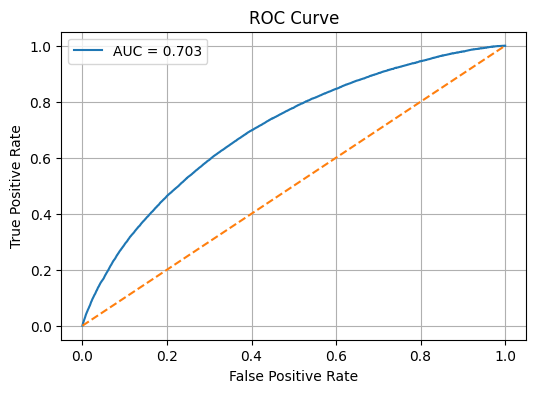

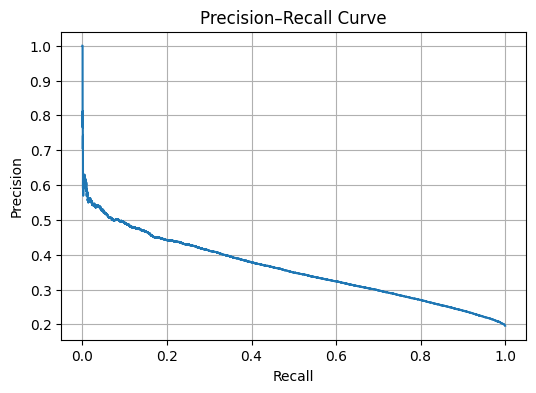

[[52008 27582]
 [ 6921 12497]]
              precision    recall  f1-score   support

           0      0.883     0.653     0.751     79590
           1      0.312     0.644     0.420     19418

    accuracy                          0.652     99008
   macro avg      0.597     0.649     0.586     99008
weighted avg      0.771     0.652     0.686     99008



In [13]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision–Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_prob)
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()

# Confusion Matrix + Report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))


In [15]:
# Get column names that match the scaled data
coef = pd.Series(model.coef_[0], index=X.columns[:len(model.coef_[0])])

# Show top 10 most influential features
print("Top 10 important features:")
print(coef.abs().sort_values(ascending=False).head(10))


Top 10 important features:
loan_amnt           0.593405
int_rate            0.552508
installment         0.465991
issue_d             0.183538
annual_inc          0.168368
is_mort_acc_gt1     0.110966
dti                 0.106176
earliest_cr_line    0.099659
pub_rec             0.094735
revol_bal           0.093763
dtype: float64


# Recommendations
Focus on Recall to identify defaulters early.

Reject high-risk profiles with large loan amounts, high DTI, or multiple public records.

Reward low-risk borrowers with lower interest rates.

Review borderline cases manually and retrain model periodically.